# (Optional) Colab Setup
If you aren't using Colab, you can delete the following code cell. This is just to help students with mounting to Google Drive to access the other .py files and downloading the data, which is a little trickier on Colab than on your local machine using Jupyter. 

In [1]:
# you will be prompted with a window asking to grant permissions
from google.colab import drive
drive.mount("/content/drive")

ModuleNotFoundError: No module named 'google'

In [1]:
# fill in the path in your Google Drive in the string below. Note: do not escape slashes or spaces
import os
datadir = r"C:\Users\thene\Downloads\assignment1 (2)\assignment1"


In [2]:
import os

# Define the directory path
datadir = r"C:\Users\thene\Downloads\assignment1 (2)\assignment1"

# Change to the target directory
os.chdir(os.path.join(datadir, "fashion-mnist"))

# Run the shell script using WSL (Windows Subsystem for Linux)
!wsl chmod +x get_data.sh
!wsl ./get_data.sh

# Change back to the original directory
os.chdir(datadir)

--2025-02-20 22:27:00--  https://raw.githubusercontent.com/zalandoresearch/fashion-mnist/master/data/fashion/t10k-images-idx3-ubyte.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4422102 (4.2M) [application/octet-stream]
Saving to: â€˜t10k-images-idx3-ubyte.gz.35â€™

     0K .......... .......... .......... .......... ..........  1% 3.19M 1s
    50K .......... .......... .......... .......... ..........  2% 2.84M 1s
   100K .......... .......... .......... .......... ..........  3% 3.52M 1s
   150K .......... .......... .......... .......... ..........  4% 9.98M 1s
   200K .......... .......... .......... .......... ..........  5% 10.7M 1s
   250K .......... .......... .......... .......... ..........  6% 11.4M 1s
   300K .......... .......... ..........

# Imports

In [3]:
import random
import numpy as np
from data_process import get_FASHION_data, get_RICE_data
from scipy.spatial import distance
from models import Perceptron, SVM, Softmax, Logistic
from kaggle_submission import output_submission_csv
%matplotlib inline

# For auto-reloading external modules
# See http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython

%reload_ext autoreload

# Loading Fashion-MNIST

In the following cells we determine the number of images for each split and load the images.
<br /> 
TRAIN_IMAGES + VAL_IMAGES = (0, 60000]
, TEST_IMAGES = 10000

In [4]:
# You can change these numbers for experimentation
# For submission we will use the default values 
TRAIN_IMAGES = 50000
VAL_IMAGES = 10000
normalize = True

In [5]:
data = get_FASHION_data(TRAIN_IMAGES, VAL_IMAGES, normalize=normalize)
X_train_fashion, y_train_fashion = data['X_train'], data['y_train']
X_val_fashion, y_val_fashion = data['X_val'], data['y_val']
X_test_fashion, y_test_fashion = data['X_test'], data['y_test']
n_class_fashion = len(np.unique(y_test_fashion))

# Loading Rice

In [6]:
# loads train / test / val splits of 80%, 20%, 20% 
data = get_RICE_data()
X_train_RICE, y_train_RICE = data['X_train'], data['y_train']
X_val_RICE, y_val_RICE = data['X_val'], data['y_val']
X_test_RICE, y_test_RICE = data['X_test'], data['y_test']
n_class_RICE = len(np.unique(y_test_RICE))

print("Number of train samples: ", X_train_RICE.shape[0])
print("Number of val samples: ", X_val_RICE.shape[0])
print("Number of test samples: ", X_test_RICE.shape[0])

Number of train samples:  10911
Number of val samples:  3637
Number of test samples:  3637


### Get Accuracy

This function computes how well your model performs using accuracy as a metric.

In [7]:
def get_acc(pred, y_test):
    return np.sum(y_test == pred) / len(y_test) * 100

# Perceptron

Perceptron has 2 hyperparameters that you can experiment with:
### Learning rate
The learning rate controls how much we change the current weights of the classifier during each update. We set it at a default value of 0.5, but you should experiment with different values. Here is a guide to help you find a right learning rate: 
- Try values ranging from 5.0 to 0.0005 to see the impact on model accuracy. 
- If the accuracy fluctuates a lot or diverges, the learning rate is too high. Try decreasing it by a factor of 10 (e.g. from 0.5 to 0.05). 
- If the accuracy is changing very slowly, the learning rate may be too low. Try increasing it by a factor of 10.
- You can also try adding a learning rate decay to slowly reduce the learning rate over each training epoch. For example, multiply the learning rate by 0.95 after each epoch.
- Plot training and validation accuracy over epochs for different learning rates. This will help you visualize the impact of the learning rate.
- [Here](https://towardsdatascience.com/https-medium-com-dashingaditya-rakhecha-understanding-learning-rate-dd5da26bb6de) is a detailed guide to learning rate.

### Number of Epochs
An epoch is a complete iterative pass over all of the data in the dataset. During an epoch we predict a label using the classifier and then update the weights of the classifier according to the perceptron update rule for each sample in the training set. You should try different values for the number of training epochs and report your results.

You will implement the Perceptron classifier in the **models/perceptron.py**

The following code: 
- Creates an instance of the Perceptron classifier class 
- The train function of the Perceptron class is trained on the training data
- We use the predict function to find the training accuracy as well as the testing accuracy


## Train Perceptron on Fashion-MNIST

In [8]:
import matplotlib.pyplot as plt
import numpy as np

learning_rates = [5.0,0.5, 0.05]
epochs_ = [10, 50, 100, 150]
plotting_data = {}
best_training_accuracy = 0  # Variable to track the best training accuracy
best_epoch = 0  # Variable to track the epoch of the best training accuracy
best_lr = 0  # Variable to track the learning rate of the best model
best_percept_fashion = None  # Variable to hold the Perceptron model with best accuracy


# Loop through all the learning rates 
for lr in learning_rates:
    training_accuracy_var = [] #initializing training accuracy variable
    validation_accuracy_var = [] #initializing validation accuracy variable
    print('----------------------------------------')
    print('--------For Learning Rate %f -------'% (lr))
    print('----------------------------------------')
# Loop through all the different epochs 
    for n_epoch in epochs_:
        percept_fashion = Perceptron(n_class_fashion, lr, n_epoch)
        percept_fashion.train(X_train_fashion, y_train_fashion) 
        pred_training = percept_fashion.predict(X_train_fashion)
        training_accuracy = get_acc(pred_training, y_train_fashion) #training Accuracy
        print('--------Epoch %d-------'% n_epoch)
        print('The training accuracy when run on %d epoch is given by: %f' % (n_epoch,training_accuracy))
        training_accuracy_var.append(training_accuracy)     
        pred_validation = percept_fashion.predict(X_val_fashion)
        val_accuracy = get_acc(pred_validation, y_val_fashion)  #validation Accuracy
        print('The validation accuracy when run on %d epoch is given by: %f' % (n_epoch, val_accuracy))
        validation_accuracy_var.append(val_accuracy)
        pred_test = percept_fashion.predict(X_test_fashion)
        print('The testing accuracy when run on %d epoch is given by: %f' % (n_epoch, get_acc(pred_test, y_test_fashion)))
        if training_accuracy > best_training_accuracy:
            best_training_accuracy = training_accuracy
            best_epoch = n_epoch
            best_lr = lr
            best_percept_fashion = percept_fashion   # Save the model with the best training accuracy

    plotting_data[lr] = (training_accuracy_var, validation_accuracy_var) # appending to the training and validation accuracies dictionary 
print(f"For the learning rate {lr} with epoch {best_epoch} the training accuracy is {best_training_accuracy:.4f} which is the best amongs all.")
    
    # Save predictions for the best epoch
output_submission_csv(f'kaggle/perceptron_submission_fashion_best_lr_{lr}.csv', best_percept_fashion.predict(X_test_fashion))

 

----------------------------------------
--------For Learning Rate 5.000000 -------
----------------------------------------
On Epoch 1 the Learning rate is = 4.750000
On Epoch 2 the Learning rate is = 4.512500
On Epoch 3 the Learning rate is = 4.286875
On Epoch 4 the Learning rate is = 4.072531
On Epoch 5 the Learning rate is = 3.868905
On Epoch 6 the Learning rate is = 3.675459
On Epoch 7 the Learning rate is = 3.491686
On Epoch 8 the Learning rate is = 3.317102
On Epoch 9 the Learning rate is = 3.151247
On Epoch 10 the Learning rate is = 2.993685
--------Epoch 10-------
The training accuracy when run on 10 epoch is given by: 83.312000
The validation accuracy when run on 10 epoch is given by: 80.960000
The testing accuracy when run on 10 epoch is given by: 79.750000
On Epoch 1 the Learning rate is = 4.750000
On Epoch 2 the Learning rate is = 4.512500
On Epoch 3 the Learning rate is = 4.286875
On Epoch 4 the Learning rate is = 4.072531
On Epoch 5 the Learning rate is = 3.868905
On Epo

On Epoch 10 the Learning rate is = 2.993685
On Epoch 11 the Learning rate is = 2.844000
On Epoch 12 the Learning rate is = 2.701800
On Epoch 13 the Learning rate is = 2.566710
On Epoch 14 the Learning rate is = 2.438375
On Epoch 15 the Learning rate is = 2.316456
On Epoch 16 the Learning rate is = 2.200633
On Epoch 17 the Learning rate is = 2.090602
On Epoch 18 the Learning rate is = 1.986072
On Epoch 19 the Learning rate is = 1.886768
On Epoch 20 the Learning rate is = 1.792430
On Epoch 21 the Learning rate is = 1.702808
On Epoch 22 the Learning rate is = 1.617668
On Epoch 23 the Learning rate is = 1.536784
On Epoch 24 the Learning rate is = 1.459945
On Epoch 25 the Learning rate is = 1.386948
On Epoch 26 the Learning rate is = 1.317600
On Epoch 27 the Learning rate is = 1.251720
On Epoch 28 the Learning rate is = 1.189134
On Epoch 29 the Learning rate is = 1.129678
On Epoch 30 the Learning rate is = 1.073194
On Epoch 31 the Learning rate is = 1.019534
On Epoch 32 the Learning rate is

On Epoch 23 the Learning rate is = 0.153678
On Epoch 24 the Learning rate is = 0.145995
On Epoch 25 the Learning rate is = 0.138695
On Epoch 26 the Learning rate is = 0.131760
On Epoch 27 the Learning rate is = 0.125172
On Epoch 28 the Learning rate is = 0.118913
On Epoch 29 the Learning rate is = 0.112968
On Epoch 30 the Learning rate is = 0.107319
On Epoch 31 the Learning rate is = 0.101953
On Epoch 32 the Learning rate is = 0.096856
On Epoch 33 the Learning rate is = 0.092013
On Epoch 34 the Learning rate is = 0.087412
On Epoch 35 the Learning rate is = 0.083042
On Epoch 36 the Learning rate is = 0.078890
On Epoch 37 the Learning rate is = 0.074945
On Epoch 38 the Learning rate is = 0.071198
On Epoch 39 the Learning rate is = 0.067638
On Epoch 40 the Learning rate is = 0.064256
On Epoch 41 the Learning rate is = 0.061043
On Epoch 42 the Learning rate is = 0.057991
On Epoch 43 the Learning rate is = 0.055092
On Epoch 44 the Learning rate is = 0.052337
On Epoch 45 the Learning rate is

On Epoch 50 the Learning rate is = 0.038472
On Epoch 51 the Learning rate is = 0.036549
On Epoch 52 the Learning rate is = 0.034721
On Epoch 53 the Learning rate is = 0.032985
On Epoch 54 the Learning rate is = 0.031336
On Epoch 55 the Learning rate is = 0.029769
On Epoch 56 the Learning rate is = 0.028281
On Epoch 57 the Learning rate is = 0.026867
On Epoch 58 the Learning rate is = 0.025523
On Epoch 59 the Learning rate is = 0.024247
On Epoch 60 the Learning rate is = 0.023035
On Epoch 61 the Learning rate is = 0.021883
On Epoch 62 the Learning rate is = 0.020789
On Epoch 63 the Learning rate is = 0.019750
On Epoch 64 the Learning rate is = 0.018762
On Epoch 65 the Learning rate is = 0.017824
On Epoch 66 the Learning rate is = 0.016933
On Epoch 67 the Learning rate is = 0.016086
On Epoch 68 the Learning rate is = 0.015282
On Epoch 69 the Learning rate is = 0.014518
On Epoch 70 the Learning rate is = 0.013792
On Epoch 71 the Learning rate is = 0.013102
On Epoch 72 the Learning rate is

On Epoch 8 the Learning rate is = 0.033171
On Epoch 9 the Learning rate is = 0.031512
On Epoch 10 the Learning rate is = 0.029937
On Epoch 11 the Learning rate is = 0.028440
On Epoch 12 the Learning rate is = 0.027018
On Epoch 13 the Learning rate is = 0.025667
On Epoch 14 the Learning rate is = 0.024384
On Epoch 15 the Learning rate is = 0.023165
On Epoch 16 the Learning rate is = 0.022006
On Epoch 17 the Learning rate is = 0.020906
On Epoch 18 the Learning rate is = 0.019861
On Epoch 19 the Learning rate is = 0.018868
On Epoch 20 the Learning rate is = 0.017924
On Epoch 21 the Learning rate is = 0.017028
On Epoch 22 the Learning rate is = 0.016177
On Epoch 23 the Learning rate is = 0.015368
On Epoch 24 the Learning rate is = 0.014599
On Epoch 25 the Learning rate is = 0.013869
On Epoch 26 the Learning rate is = 0.013176
On Epoch 27 the Learning rate is = 0.012517
On Epoch 28 the Learning rate is = 0.011891
On Epoch 29 the Learning rate is = 0.011297
On Epoch 30 the Learning rate is =

On Epoch 90 the Learning rate is = 0.000494
On Epoch 91 the Learning rate is = 0.000470
On Epoch 92 the Learning rate is = 0.000446
On Epoch 93 the Learning rate is = 0.000424
On Epoch 94 the Learning rate is = 0.000403
On Epoch 95 the Learning rate is = 0.000383
On Epoch 96 the Learning rate is = 0.000363
On Epoch 97 the Learning rate is = 0.000345
On Epoch 98 the Learning rate is = 0.000328
On Epoch 99 the Learning rate is = 0.000312
On Epoch 100 the Learning rate is = 0.000296
On Epoch 101 the Learning rate is = 0.000281
On Epoch 102 the Learning rate is = 0.000267
On Epoch 103 the Learning rate is = 0.000254
On Epoch 104 the Learning rate is = 0.000241
On Epoch 105 the Learning rate is = 0.000229
On Epoch 106 the Learning rate is = 0.000218
On Epoch 107 the Learning rate is = 0.000207
On Epoch 108 the Learning rate is = 0.000196
On Epoch 109 the Learning rate is = 0.000187
On Epoch 110 the Learning rate is = 0.000177
On Epoch 111 the Learning rate is = 0.000168
On Epoch 112 the Lea

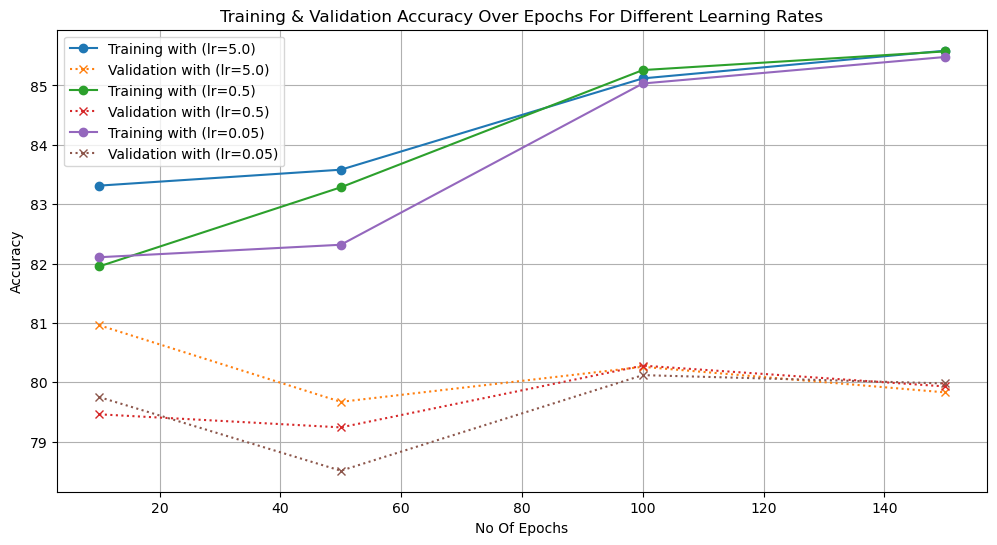

In [9]:
 #Plotting the training and validation accuracy over epochs of different learning rates
plt.figure(figsize=(12, 6))
for lr, (training_accuracy_var, validation_accuracy_var) in plotting_data.items():
    plt.plot(epochs_, training_accuracy_var, marker='o', label=f'Training with (lr={lr})')
    plt.plot(epochs_, validation_accuracy_var, linestyle='dotted', label=f'Validation with (lr={lr})', marker='x')
plt.title("Training & Validation Accuracy Over Epochs For Different Learning Rates")
plt.ylabel("Accuracy")
plt.xlabel("No Of Epochs")
plt.legend()
plt.grid()
plt.show()  

## Train Perceptron on Rice

In [11]:
import matplotlib.pyplot as plt
import numpy as np

learning_rates = [5.0,0.5, 0.05]
epochs_ = [10, 60, 90, 110]
plotting_data = {}

# Loop through all the learning rates 
for lr in learning_rates:
    training_accuracy_var = [] #initializing training accuracy variable
    validation_accuracy_var = [] #initializing validation accuracy variable
    print('----------------------------------------')
    print('--------For Learning Rate %f -------'% (lr))
    print('----------------------------------------')
# Loop through all the different epochs 
    for n_epoch in epochs_:
        percept_RICE = Perceptron(n_class_RICE, lr, n_epoch)
        percept_RICE.train(X_train_RICE, y_train_RICE) 
        pred_training = percept_RICE.predict(X_train_RICE)
        training_accuracy = get_acc(pred_training, y_train_RICE) #training Accuracy
        print('--------Epoch %d-------'% n_epoch)
        print('The training accuracy when run on %d epoch is given by: %f' % (n_epoch,training_accuracy))
        training_accuracy_var.append(training_accuracy)     
        pred_validation = percept_RICE.predict(X_val_RICE)
        val_accuracy = get_acc(pred_validation, y_val_RICE)  #validation Accuracy
        print('The validation accuracy when run on %d epoch is given by: %f' % (n_epoch,val_accuracy))
        validation_accuracy_var.append(val_accuracy)
        pred_test = percept_RICE.predict(X_test_RICE)
        print('The testing accuracy when run on %d epoch is given by: %f' % (n_epoch, get_acc(pred_test, y_test_RICE)))
    plotting_data[lr] = (training_accuracy_var, validation_accuracy_var) # appending to the training and validation accuracies dictionary 

 

----------------------------------------
--------For Learning Rate 5.000000 -------
----------------------------------------
On Epoch 1 the Learning rate is = 4.750000
On Epoch 2 the Learning rate is = 4.512500
On Epoch 3 the Learning rate is = 4.286875
On Epoch 4 the Learning rate is = 4.072531
On Epoch 5 the Learning rate is = 3.868905
On Epoch 6 the Learning rate is = 3.675459
On Epoch 7 the Learning rate is = 3.491686
On Epoch 8 the Learning rate is = 3.317102
On Epoch 9 the Learning rate is = 3.151247
On Epoch 10 the Learning rate is = 2.993685
--------Epoch 10-------
The training accuracy when run on 10 epoch is given by: 98.121162
The validation accuracy when run on 10 epoch is given by: 98.185318
The testing accuracy when run on 10 epoch is given by: 98.020346
On Epoch 1 the Learning rate is = 4.750000
On Epoch 2 the Learning rate is = 4.512500
On Epoch 3 the Learning rate is = 4.286875
On Epoch 4 the Learning rate is = 4.072531
On Epoch 5 the Learning rate is = 3.868905
On Epo

On Epoch 10 the Learning rate is = 2.993685
On Epoch 11 the Learning rate is = 2.844000
On Epoch 12 the Learning rate is = 2.701800
On Epoch 13 the Learning rate is = 2.566710
On Epoch 14 the Learning rate is = 2.438375
On Epoch 15 the Learning rate is = 2.316456
On Epoch 16 the Learning rate is = 2.200633
On Epoch 17 the Learning rate is = 2.090602
On Epoch 18 the Learning rate is = 1.986072
On Epoch 19 the Learning rate is = 1.886768
On Epoch 20 the Learning rate is = 1.792430
On Epoch 21 the Learning rate is = 1.702808
On Epoch 22 the Learning rate is = 1.617668
On Epoch 23 the Learning rate is = 1.536784
On Epoch 24 the Learning rate is = 1.459945
On Epoch 25 the Learning rate is = 1.386948
On Epoch 26 the Learning rate is = 1.317600
On Epoch 27 the Learning rate is = 1.251720
On Epoch 28 the Learning rate is = 1.189134
On Epoch 29 the Learning rate is = 1.129678
On Epoch 30 the Learning rate is = 1.073194
On Epoch 31 the Learning rate is = 1.019534
On Epoch 32 the Learning rate is

On Epoch 1 the Learning rate is = 0.475000
On Epoch 2 the Learning rate is = 0.451250
On Epoch 3 the Learning rate is = 0.428687
On Epoch 4 the Learning rate is = 0.407253
On Epoch 5 the Learning rate is = 0.386890
On Epoch 6 the Learning rate is = 0.367546
On Epoch 7 the Learning rate is = 0.349169
On Epoch 8 the Learning rate is = 0.331710
On Epoch 9 the Learning rate is = 0.315125
On Epoch 10 the Learning rate is = 0.299368
On Epoch 11 the Learning rate is = 0.284400
On Epoch 12 the Learning rate is = 0.270180
On Epoch 13 the Learning rate is = 0.256671
On Epoch 14 the Learning rate is = 0.243837
On Epoch 15 the Learning rate is = 0.231646
On Epoch 16 the Learning rate is = 0.220063
On Epoch 17 the Learning rate is = 0.209060
On Epoch 18 the Learning rate is = 0.198607
On Epoch 19 the Learning rate is = 0.188677
On Epoch 20 the Learning rate is = 0.179243
On Epoch 21 the Learning rate is = 0.170281
On Epoch 22 the Learning rate is = 0.161767
On Epoch 23 the Learning rate is = 0.1536

On Epoch 94 the Learning rate is = 0.004027
On Epoch 95 the Learning rate is = 0.003826
On Epoch 96 the Learning rate is = 0.003634
On Epoch 97 the Learning rate is = 0.003453
On Epoch 98 the Learning rate is = 0.003280
On Epoch 99 the Learning rate is = 0.003116
On Epoch 100 the Learning rate is = 0.002960
On Epoch 101 the Learning rate is = 0.002812
On Epoch 102 the Learning rate is = 0.002672
On Epoch 103 the Learning rate is = 0.002538
On Epoch 104 the Learning rate is = 0.002411
On Epoch 105 the Learning rate is = 0.002291
On Epoch 106 the Learning rate is = 0.002176
On Epoch 107 the Learning rate is = 0.002067
On Epoch 108 the Learning rate is = 0.001964
On Epoch 109 the Learning rate is = 0.001866
On Epoch 110 the Learning rate is = 0.001772
--------Epoch 110-------
The training accuracy when run on 110 epoch is given by: 99.935845
The validation accuracy when run on 110 epoch is given by: 99.890019
The testing accuracy when run on 110 epoch is given by: 99.917514
--------------

On Epoch 84 the Learning rate is = 0.000673
On Epoch 85 the Learning rate is = 0.000639
On Epoch 86 the Learning rate is = 0.000607
On Epoch 87 the Learning rate is = 0.000577
On Epoch 88 the Learning rate is = 0.000548
On Epoch 89 the Learning rate is = 0.000520
On Epoch 90 the Learning rate is = 0.000494
--------Epoch 90-------
The training accuracy when run on 90 epoch is given by: 99.945010
The validation accuracy when run on 90 epoch is given by: 99.862524
The testing accuracy when run on 90 epoch is given by: 99.917514
On Epoch 1 the Learning rate is = 0.047500
On Epoch 2 the Learning rate is = 0.045125
On Epoch 3 the Learning rate is = 0.042869
On Epoch 4 the Learning rate is = 0.040725
On Epoch 5 the Learning rate is = 0.038689
On Epoch 6 the Learning rate is = 0.036755
On Epoch 7 the Learning rate is = 0.034917
On Epoch 8 the Learning rate is = 0.033171
On Epoch 9 the Learning rate is = 0.031512
On Epoch 10 the Learning rate is = 0.029937
On Epoch 11 the Learning rate is = 0.0

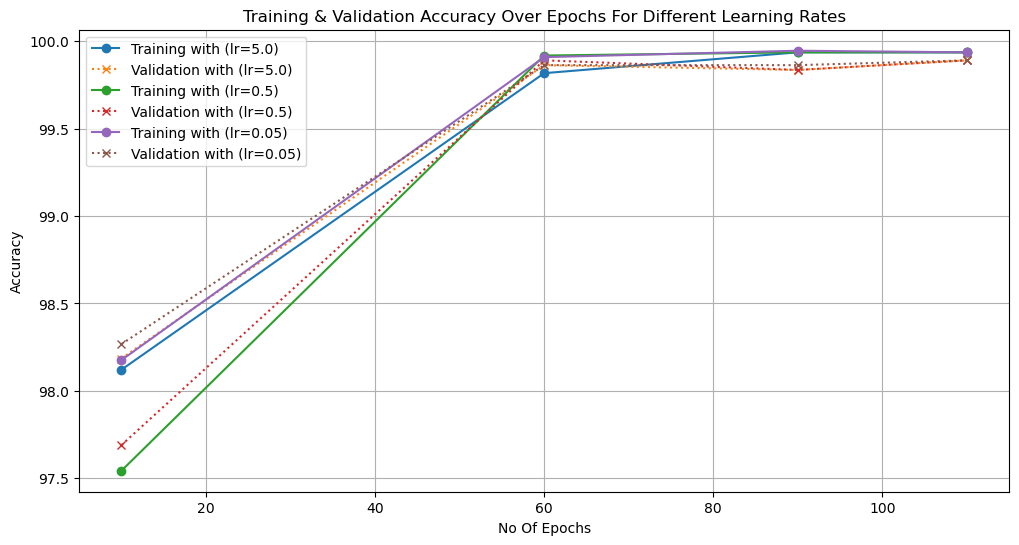

In [12]:
 #Plotting the training and validation accuracy over epochs of different learning rates
plt.figure(figsize=(12, 6))
for lr, (training_accuracy_var, validation_accuracy_var) in plotting_data.items():
    plt.plot(epochs_, training_accuracy_var, marker='o', label=f'Training with (lr={lr})')
    plt.plot(epochs_, validation_accuracy_var, linestyle='dotted', label=f'Validation with (lr={lr})', marker='x')
plt.title("Training & Validation Accuracy Over Epochs For Different Learning Rates")
plt.ylabel("Accuracy")
plt.xlabel("No Of Epochs")
plt.legend()
plt.grid()
plt.show() 

# Support Vector Machines (with SGD)

Next, you will implement a "soft margin" SVM. In this formulation you will maximize the margin between positive and negative training examples and penalize margin violations using a hinge loss.

We will optimize the SVM loss using SGD. This means you must compute the loss function with respect to model weights. You will use this gradient to update the model weights.

SVM optimized with SGD has 3 hyperparameters that you can experiment with:
- **Learning rate** - similar to as defined above in Perceptron, this parameter scales by how much the weights are changed according to the calculated gradient update. 
- **Epochs** - similar to as defined above in Perceptron.
- **Regularization constant** - Hyperparameter to determine the strength of regularization. In this case it is a coefficient on the term which maximizes the margin. You could try different values. The default value is set to 0.05.

You will implement the SVM using SGD in the **models/svm.py**

The following code: 
- Creates an instance of the SVM classifier class 
- The train function of the SVM class is trained on the training data
- We use the predict function to find the training accuracy as well as the testing accuracy

## Train SVM on Fashion-MNIST

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Initialize necessary variables
epochs = 110
learning_rates = [0.05, 0.005]
reg_consts = [0.5, 0.005]
plotting_data = {}
hinge_loss_data = {}

best_training_accuracy = 0
best_epoch = 0
best_lr = 0
best_reg_const = 0
best_svm_model = None

# Loop through all the learning rates
for lr in learning_rates:
    training_accuracy_var = []  # Initialize training accuracy variable
    validation_accuracy_var = []  # Initialize validation accuracy variable
    print('----------------------------------------')
    print(f'--------For Learning Rate {lr} -------')
    print('----------------------------------------')
    
    for reg_const in reg_consts:
        svm_fashion = SVM(n_class_fashion, lr, epochs, reg_const)  # Set epochs to 110
        hinge_loss_history = svm_fashion.train(X_train_fashion, y_train_fashion)
        hinge_loss_data[(lr, reg_const, epochs)] = hinge_loss_history
        
        pred_svm_training = svm_fashion.predict(X_train_fashion)
        training_accuracy = get_acc(pred_svm_training, y_train_fashion)  # Training Accuracy
        print(f'--------Epoch {epochs} with Regularization constant {reg_const}-------')
        print(f'The training accuracy is given by: {training_accuracy}')
        training_accuracy_var.append(training_accuracy)

        pred_validation = svm_fashion.predict(X_val_fashion)
        val_accuracy = get_acc(pred_validation, y_val_fashion)  # Validation Accuracy
        print(f'The validation accuracy is given by: {val_accuracy}')
        validation_accuracy_var.append(val_accuracy)
        
        pred_test = svm_fashion.predict(X_test_fashion)
        print(f'The testing accuracy is given by: {get_acc(pred_test, y_test_fashion)}')

        # Track the best model
        if training_accuracy > best_training_accuracy:
            best_training_accuracy = training_accuracy
            best_epoch = epochs
            best_lr = lr
            best_reg_const = reg_const
            best_svm_model = svm_fashion
    
    # Store plotting data for accuracy
    plotting_data[lr] = (training_accuracy_var, validation_accuracy_var)

    # Print best epoch and accuracy for each learning rate
    print(f"Best epoch for learning rate {lr} and regularization constant {best_reg_const} is epoch {best_epoch} with training accuracy {best_training_accuracy:.4f}")

# Save predictions for the best model
output_submission_csv(f'kaggle/svm_submission_fashion.csv', best_svm_model.predict(X_test_fashion))




----------------------------------------
--------For Learning Rate 0.05 -------
----------------------------------------
--------Epoch 110 with Regularization constant 0.5-------
The training accuracy is given by: 49.726
The validation accuracy is given by: 49.29
The testing accuracy is given by: 48.85
--------Epoch 110 with Regularization constant 0.005-------
The training accuracy is given by: 76.29599999999999
The validation accuracy is given by: 74.88
The testing accuracy is given by: 74.66000000000001
Best epoch for learning rate 0.05 and regularization constant 0.005 is epoch 110 with training accuracy 76.2960
----------------------------------------
--------For Learning Rate 0.005 -------
----------------------------------------
--------Epoch 110 with Regularization constant 0.5-------
The training accuracy is given by: 60.85
The validation accuracy is given by: 60.38
The testing accuracy is given by: 60.589999999999996
--------Epoch 110 with Regularization constant 0.005-------

Best epoch for learning rate 0.005 and regularization constant 0.005 is epoch 110 with training accuracy 83.6740


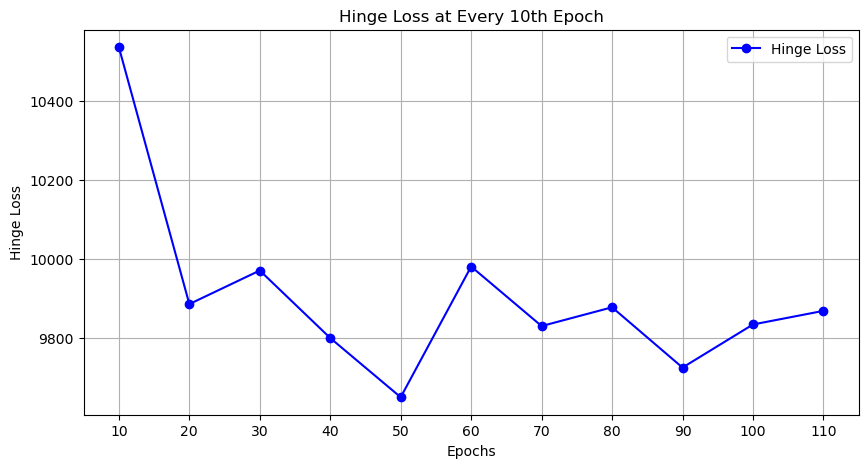

In [9]:
import numpy as np
import matplotlib.pyplot as plt
print(f"Best epoch for learning rate {best_lr} and regularization constant {best_reg_const} is epoch {epochs} with training accuracy {best_training_accuracy:.4f}")

# Function to plot hinge loss every 10th epoch
def plot_hinge_loss_at_10th_epoch(hinge_loss_history):
    """Function to plot hinge loss over every 10th epoch."""
    epochs_to_plot = range(10, 111, 10)  # 10, 20, 30, ..., 110
    hinge_loss_to_plot = [hinge_loss_history[i - 1] for i in epochs_to_plot]  # Subtract 1 for 0-based index

    plt.figure(figsize=(10, 5))
    plt.plot(epochs_to_plot, hinge_loss_to_plot, marker='o', linestyle='-', color='b', label="Hinge Loss")
    plt.title("Hinge Loss at Every 10th Epoch")
    plt.xlabel("Epochs")
    plt.ylabel("Hinge Loss")
    plt.xticks(epochs_to_plot)  # Ensure the x-axis shows only selected epochs
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot the hinge loss for the best model over every 10th epoch (10, 20, ..., 110)
plot_hinge_loss_at_10th_epoch(hinge_loss_data[(best_lr, best_reg_const, epochs)])


## Train SVM on Rice

In [11]:
import matplotlib.pyplot as plt
import numpy as np

learning_rates = [5.0,0.5, 0.05]
epochs_ = [60, 110]
reg_consts = [0.05,0.005]
best_training_accuracy = 0  # Variable to track best training accuracy
best_epoch = 0  # Variable to track the best epoch
best_reg_const = 0  # Variable to track the best regularization constant
best_svm_model = None  # Variable to hold the best SVM model
# Loop through all the learning rates 
for lr in learning_rates:
    training_accuracy_var = [] #initializing training accuracy variable
    validation_accuracy_var = [] #initializing validation accuracy variable

    print('----------------------------------------')
    print('--------For Learning Rate %f -------'% (lr))
    print('----------------------------------------')
    for reg_const in reg_consts:
        for n_epoch in epochs_:
            svm_RICE = SVM(n_class_RICE, lr, n_epoch, reg_const)
            svm_RICE.train(X_train_RICE, y_train_RICE) 
            pred_svm_training = svm_RICE.predict(X_train_RICE)
            training_accuracy = get_acc(pred_svm_training, y_train_RICE) #training Accuracy
            print('--------Epoch %d with Regularization constant %f-------'% (n_epoch,reg_const))
            print('The training accuracy is given by: %f' % (training_accuracy))
            training_accuracy_var.append(training_accuracy)     
            pred_validation = svm_RICE.predict(X_val_RICE)
            val_accuracy = get_acc(pred_validation, y_val_RICE)  #validation Accuracy
            print('The validation accuracy is given by: %f' % (val_accuracy))
            validation_accuracy_var.append(val_accuracy)
            pred_test = svm_RICE.predict(X_test_RICE)
            print('The testing accuracy is given by: %f' % ( get_acc(pred_test, y_test_RICE)))
            if training_accuracy > best_training_accuracy:
                best_training_accuracy = training_accuracy
                best_epoch = n_epoch
                best_reg_const = reg_const
                best_svm_model = svm_RICE 
    
print(f"Best training accuracy for learning rate {lr} and regularization constant {best_reg_const} with epochs {best_epoch} is {best_training_accuracy:.4f}")
    


----------------------------------------
--------For Learning Rate 5.000000 -------
----------------------------------------
--------Epoch 60 with Regularization constant 0.050000-------
The training accuracy is given by: 54.779580
The validation accuracy is given by: 56.145175
The testing accuracy is given by: 54.055540
--------Epoch 110 with Regularization constant 0.050000-------
The training accuracy is given by: 45.220420
The validation accuracy is given by: 43.854825
The testing accuracy is given by: 45.944460
--------Epoch 60 with Regularization constant 0.005000-------
The training accuracy is given by: 70.662634
The validation accuracy is given by: 69.122903
The testing accuracy is given by: 69.920264
--------Epoch 110 with Regularization constant 0.005000-------
The training accuracy is given by: 59.362112
The validation accuracy is given by: 58.207314
The testing accuracy is given by: 60.159472
----------------------------------------
--------For Learning Rate 0.500000 -----

# Softmax Classifier (with SGD)

Next, you will train a Softmax classifier. This classifier consists of a linear function of the input data followed by a softmax function which outputs a vector of dimension C (number of classes) for each data point. Each entry of the softmax output vector corresponds to a confidence in one of the C classes, and like a probability distribution, the entries of the output vector sum to 1. We use a cross-entropy loss on this sotmax output to train the model. 

Check the following link as an additional resource on softmax classification: http://cs231n.github.io/linear-classify/#softmax

Once again we will train the classifier with SGD. This means you need to compute the gradients of the softmax cross-entropy loss function according to the weights and update the weights using this gradient. Check the following link to help with implementing the gradient updates: https://deepnotes.io/softmax-crossentropy

The softmax classifier has 3 hyperparameters that you can experiment with:
- **Learning rate** - As above, this controls how much the model weights are updated with respect to their gradient.
- **Number of Epochs** - As described for perceptron.
- **Regularization constant** - Hyperparameter to determine the strength of regularization. In this case, we minimize the L2 norm of the model weights as regularization, so the regularization constant is a coefficient on the L2 norm in the combined cross-entropy and regularization objective.

You will implement a softmax classifier using SGD in the **models/softmax.py**

The following code: 
- Creates an instance of the Softmax classifier class 
- The train function of the Softmax class is trained on the training data
- We use the predict function to find the training accuracy as well as the testing accuracy

## Train Softmax on Fashion-MNIST

In [14]:
import matplotlib.pyplot as plt
import numpy as np

learning_rates = [5.0,0.5, 0.05]
epochs_ = [70, 130]
reg_consts = [0.05,0.005]
best_training_accuracy = 0  # Variable to track best training accuracy
best_epoch = 0  # Variable to track the best epoch
best_reg_const = 0  # Variable to track the best regularization constant
best_softmax_model = None  # Variable to hold the best SVM model

# Loop through all the learning rates 
for lr in learning_rates:
    training_accuracy_var = [] #initializing training accuracy variable
    validation_accuracy_var = [] #initializing validation accuracy variable
    print('----------------------------------------')
    print('--------For Learning Rate %f -------'% (lr))
    print('----------------------------------------')
    for reg_const in reg_consts:
        for n_epoch in epochs_:
            softmax_fashion = Softmax(n_class_fashion, lr, n_epoch, reg_const)
            softmax_fashion.train(X_train_fashion, y_train_fashion) 
            pred_softmax_training = softmax_fashion.predict(X_train_fashion)
            training_accuracy = get_acc(pred_softmax_training, y_train_fashion) #training Accuracy
            print('--------Epoch %d with Regularization constant %f-------'% (n_epoch,reg_const))
            print('The training accuracy is given by: %f' % (training_accuracy))
            training_accuracy_var.append(training_accuracy)     
            pred_validation = softmax_fashion.predict(X_val_fashion)
            val_accuracy = get_acc(pred_validation, y_val_fashion)  #validation Accuracy
            print('The validation accuracy is given by: %f' % (val_accuracy))
            validation_accuracy_var.append(val_accuracy)
            pred_test = softmax_fashion.predict(X_test_fashion)
            print('The testing accuracy is given by: %f' % ( get_acc(pred_test, y_test_fashion)))
            if training_accuracy > best_training_accuracy:
                best_training_accuracy = training_accuracy
                best_epoch = n_epoch
                best_reg_const = reg_const
                best_softmax_model = softmax_fashion

print(f"Best training accuracy for learning rate {lr} and regularization constant {best_reg_const} with epochs {best_epoch} is {best_training_accuracy:.4f}")
     

----------------------------------------
--------For Learning Rate 5.000000 -------
----------------------------------------
--------Epoch 70 with Regularization constant 0.050000-------
The training accuracy is given by: 27.090000
The validation accuracy is given by: 27.650000
The testing accuracy is given by: 26.690000
--------Epoch 130 with Regularization constant 0.050000-------
The training accuracy is given by: 25.598000
The validation accuracy is given by: 25.780000
The testing accuracy is given by: 25.170000
--------Epoch 70 with Regularization constant 0.005000-------
The training accuracy is given by: 51.700000
The validation accuracy is given by: 51.560000
The testing accuracy is given by: 51.440000
--------Epoch 130 with Regularization constant 0.005000-------
The training accuracy is given by: 62.326000
The validation accuracy is given by: 62.630000
The testing accuracy is given by: 62.050000
----------------------------------------
--------For Learning Rate 0.500000 -----

In [18]:

output_submission_csv(f'kaggle/softmax_submission_fashion.csv', best_softmax_model.predict(X_train_fashion))

## Train Softmax on Rice

In [23]:
import matplotlib.pyplot as plt
import numpy as np

learning_rates = [5.0,0.5, 0.05]
epochs_ = [70, 110]
reg_consts = [0.05,0.005,0.0005]
best_training_accuracy = 0  # Variable to track best training accuracy
best_epoch = 0  # Variable to track the best epoch
best_reg_const = 0  # Variable to track the best regularization constant
best_softmax_model = None  # Variable to hold the best SVM model

# Loop through all the learning rates 
for lr in learning_rates:
    training_accuracy_var = [] #initializing training accuracy variable
    validation_accuracy_var = [] #initializing validation accuracy variable
    print('----------------------------------------')
    print('--------For Learning Rate %f -------'% (lr))
    print('----------------------------------------')
    for reg_const in reg_consts:
        for n_epoch in epochs_:
            softmax_RICE = Softmax(n_class_RICE, lr, n_epochs, reg_const)
            softmax_RICE.train(X_train_RICE, y_train_RICE)
            pred_softmax_training = softmax_RICE.predict(X_train_RICE)
            training_accuracy = get_acc(pred_softmax_training, y_train_RICE) #training Accuracy
            print('--------Epoch %d with Regularization constant %f-------'% (n_epoch,reg_const))
            print('The training accuracy is given by: %f' % (training_accuracy))
            training_accuracy_var.append(training_accuracy)     
            pred_validation = softmax_RICE.predict(X_val_RICE)
            val_accuracy = get_acc(pred_validation, y_val_RICE)  #validation Accuracy
            print('The validation accuracy is given by: %f' % (val_accuracy))
            validation_accuracy_var.append(val_accuracy)
            pred_test = softmax_RICE.predict(X_test_RICE)
            print('The testing accuracy is given by: %f' % ( get_acc(pred_test, y_test_RICE)))
            if training_accuracy > best_training_accuracy:
                best_training_accuracy = training_accuracy
                best_epoch = n_epoch
                best_reg_const = reg_const
                best_softmax_model = softmax_fashion
                
print(f"Best training accuracy for learning rate {lr} and regularization constant {best_reg_const} with epochs {best_epoch} is {best_training_accuracy:.4f}")    

----------------------------------------
--------For Learning Rate 5.000000 -------
----------------------------------------
--------Epoch 70 with Regularization constant 0.050000-------
The training accuracy is given by: 45.220420
The validation accuracy is given by: 43.854825
The testing accuracy is given by: 45.944460
--------Epoch 110 with Regularization constant 0.050000-------
The training accuracy is given by: 45.220420
The validation accuracy is given by: 43.854825
The testing accuracy is given by: 45.944460
--------Epoch 70 with Regularization constant 0.005000-------
The training accuracy is given by: 62.597379
The validation accuracy is given by: 64.503712
The testing accuracy is given by: 62.991476
--------Epoch 110 with Regularization constant 0.005000-------
The training accuracy is given by: 59.976171
The validation accuracy is given by: 61.644212
The testing accuracy is given by: 59.994501
--------Epoch 70 with Regularization constant 0.000500-------
The training accura

# Logistic Classifier

The Logistic Classifier has 2 hyperparameters that you can experiment with:
- **Learning rate** - similar to as defined above in Perceptron, this parameter scales by how much the weights are changed according to the calculated gradient update. 
- **Number of Epochs** - As described for perceptron.
- **Threshold** - The decision boundary of the classifier.


You will implement the Logistic Classifier in the **models/logistic.py**

The following code: 
- Creates an instance of the Logistic classifier class 
- The train function of the Logistic class is trained on the training data
- We use the predict function to find the training accuracy as well as the testing accuracy

In [20]:
import matplotlib.pyplot as plt
import numpy as np

learning_rates = [5.0,0.5, 0.05,0.005]
epochs_ = [50, 70, 110,140]
threshold = 0.5
plotting_data = {}

# Loop through all the learning rates 
for lr in learning_rates:
    training_accuracy_var = [] #initializing training accuracy variable
    validation_accuracy_var = [] #initializing validation accuracy variable
    print('----------------------------------------')
    print('--------For Learning Rate %f -------'% (lr))
    print('----------------------------------------')
    for n_epoch in epochs_:
        logistic_ = Logistic(lr, n_epoch, threshold)
        logistic_.train(X_train_RICE, y_train_RICE)
        pred_Logistic_training = logistic_.predict(X_train_RICE)
        training_accuracy = get_acc(pred_Logistic_training, y_train_RICE) #training Accuracy
        print('--------Epoch %d with Regularization constant %f-------'% (n_epoch,threshold))
        print('The training accuracy is given by: %f' % (training_accuracy))
        training_accuracy_var.append(training_accuracy)     
        pred_validation = logistic_.predict(X_val_RICE)
        val_accuracy = get_acc(pred_validation, y_val_RICE)  #validation Accuracy
        print('The validation accuracy is given by: %f' % (val_accuracy))
        validation_accuracy_var.append(val_accuracy)
        pred_test = logistic_.predict(X_test_RICE)
        print('The testing accuracy is given by: %f' % ( get_acc(pred_test, y_test_RICE)))
    plotting_data[lr] = (training_accuracy_var, validation_accuracy_var) # appending to the training and validation accuracies dictionary 



----------------------------------------
--------For Learning Rate 5.000000 -------
----------------------------------------
--------Epoch 50 with Regularization constant 0.500000-------
The training accuracy is given by: 68.655485
The validation accuracy is given by: 69.755293
The testing accuracy is given by: 68.957932
--------Epoch 70 with Regularization constant 0.500000-------
The training accuracy is given by: 68.893777
The validation accuracy is given by: 69.947759
The testing accuracy is given by: 69.067913
--------Epoch 110 with Regularization constant 0.500000-------
The training accuracy is given by: 68.802126
The validation accuracy is given by: 69.920264
The testing accuracy is given by: 69.067913
--------Epoch 140 with Regularization constant 0.500000-------
The training accuracy is given by: 75.575108
The validation accuracy is given by: 75.996701
The testing accuracy is given by: 74.649436
----------------------------------------
--------For Learning Rate 0.500000 -----

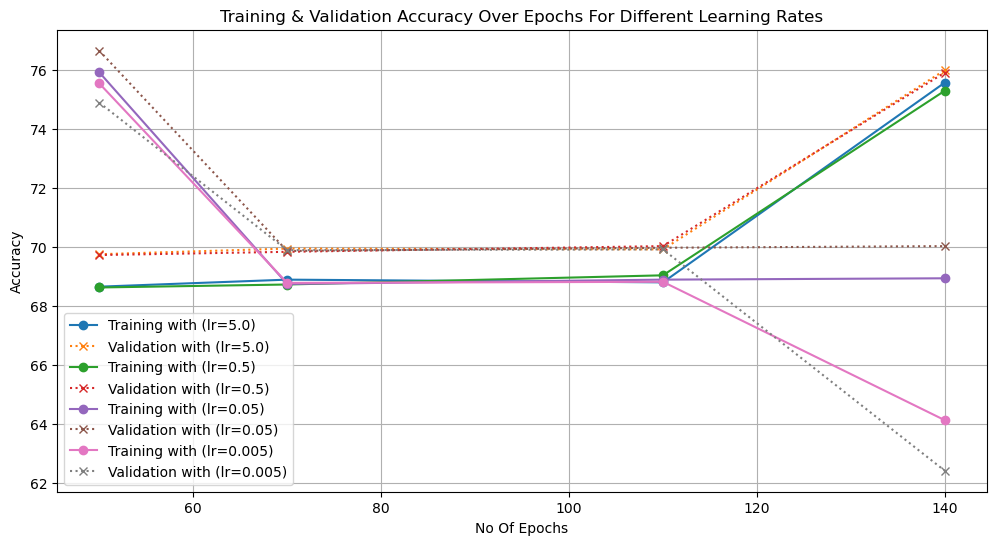

In [21]:
 #Plotting the training and validation accuracy over epochs of different learning rates
plt.figure(figsize=(12, 6))
for lr, (training_accuracy_var, validation_accuracy_var) in plotting_data.items():
    plt.plot(epochs_, training_accuracy_var, marker='o', label=f'Training with (lr={lr})')
    plt.plot(epochs_, validation_accuracy_var, linestyle='dotted', label=f'Validation with (lr={lr})', marker='x')
plt.title("Training & Validation Accuracy Over Epochs For Different Learning Rates")
plt.ylabel("Accuracy")
plt.xlabel("No Of Epochs")
plt.legend()
plt.grid()
plt.show()  